PAGA stuff1

In [1]:
## load 
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os 
import csv
from astropy.io import ascii
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN
import warnings
from pathlib import Path
from scipy import stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
warnings.filterwarnings('ignore')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.4 numpy==1.19.1 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [2]:
code_dir ='/mnt/d/Huitian_Practice/exp391'
os.chdir(code_dir)

In [ ]:
code_dir

In [3]:

wk_dir = code_dir + "/1_Scanpy_2"
Path(wk_dir).mkdir(parents=True, exist_ok=True)


In [4]:
analysis_name = ['0', 'basic']
new_wk_dir = wk_dir + "/%s_Scanpy_out_%s"%(analysis_name[0],analysis_name[1])
Path(new_wk_dir).mkdir(parents=True, exist_ok=True)
sp_name='exp391'
outname_base = sp_name
print(sp_name, analysis_name)

exp391 ['0', 'basic']


In [6]:
min_gene_nu, min_cell_nu = 500, 3
min_g_nav, max_g_nav = 1200,2500
min_m_nav,max_m_nav = 0.02, 0.08
min_c_nav, max_c_nav = 2000, 10000

min_g_a, max_g_a = 1000, 8000
min_m_a, max_m_a = 0.01, 0.07
min_c_a, max_c_a = 2000, 65000

fa_n_denoise, fa_pc_denoise = 200, 50
fa_n, fa_pc = 250, 30
max_n_per_cond = 1250
filter_celltypes = ["NWT"]

In [7]:

mtx_dir = code_dir + "/filtered_feature_bc_matrix"
sc.settings.verbosity = 3
results_file = './write/%s_paga.h5ad'%outname_base

In [ ]:
mtx_dir

In [8]:
adata = sc.read_10x_mtx(mtx_dir,var_names='gene_symbols',cache=True)

... reading from cache file cache/mnt-d-Huitian_Practice-exp391-filtered_feature_bc_matrix-matrix.h5ad


In [8]:
adata.shape

(18353, 22630)

In [9]:
adata.X.astype('float64')

<18353x22630 sparse matrix of type '<class 'numpy.float64'>'
	with 60391080 stored elements in Compressed Sparse Row format>

In [10]:
adata.var_names_make_unique()

In [ ]:
adata

In [11]:
cell_type_info = code_dir + "/Hashtag_count_new2/exp391_Cells_hashTags.csv"

In [12]:
with open(cell_type_info, 'r') as f:
    reader = csv.reader(f)
    cell_type_list = list(reader)
cell_type_list = [x[0] for x in cell_type_list]

In [ ]:
cell_type_list[0:3]


In [13]:
adata.obs['cell_type'] = cell_type_list

In [14]:
adata = adata[adata.obs['cell_type'] != "Doublet", :]

In [15]:
adata = adata[adata.obs['cell_type'] != "Negative", :]

In [16]:
adata

View of AnnData object with n_obs × n_vars = 14595 × 22630
    obs: 'cell_type'
    var: 'gene_ids', 'feature_types'

In [17]:
for i in filter_celltypes:
    adata = adata[adata.obs['cell_type'] != i, :]

In [18]:
adata.shape

(13802, 22630)

In [19]:
sc.pp.filter_cells(adata,min_genes=min_gene_nu)

filtered out 589 cells that have less than 500 genes expressed


Trying to set attribute `.obs` of view, copying.


In [20]:
adata

AnnData object with n_obs × n_vars = 13213 × 22630
    obs: 'cell_type', 'n_genes'
    var: 'gene_ids', 'feature_types'

In [21]:
sc.pp.filter_genes(adata,min_cells=min_cell_nu)

filtered out 8117 genes that are detected in less than 3 cells


In [ ]:
adata

In [22]:
mito_genes=adata.var_names.str.startswith('mt-')

In [23]:
check = adata.var_names[mito_genes]
check

Index(['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3',
       'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb'],
      dtype='object')

In [24]:
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X,axis=1).A1/np.sum(adata.X,axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1


In [ ]:
check = np.sum(adata[:,mito_genes].X,axis=1)
check[1:4]
adata.obs['n_counts'][0:4]
adata.obs['percent_mito'][0:4]

In [ ]:
adata

In [ ]:
adata.obs['cell_type'][0:30]

In [25]:
use_list = []
for i in range(len(adata.obs)):
    if adata.obs['cell_type'][i] != "NP14B":
        use_list.append(True)
    else:
        i_genes = ((adata.obs['n_genes'][i] >= min_g_nav) and (adata.obs['n_genes'][i] <= max_g_nav))
        i_mito = ((adata.obs['percent_mito'][i] >= min_m_nav) and (adata.obs['percent_mito'][i] <= max_m_nav))
        i_c = ((adata.obs['n_counts'][i] >= min_c_nav) and (adata.obs['n_counts'][i] <= max_c_nav))
        if all([i_genes,i_mito,i_c]):
            use_list.append(True)
        else:
            use_list.append(False)

In [ ]:
adata.obs['percent_mito'][0:4]

In [ ]:
use_list[1:4]

In [26]:
adata = adata[use_list,:]

In [ ]:
adata.obs['percent_mito'][0:4]

In [27]:
use_list = []
for i in range(len(adata.obs)):
    if adata.obs['cell_type'][i] == "NP14B":
        use_list.append(True)
    else:
        i_genes = ((adata.obs['n_genes'][i] >= min_g_a) and (adata.obs['n_genes'][i] <= max_g_a))
        i_mito = ((adata.obs['percent_mito'][i] >= min_m_a) and (adata.obs['percent_mito'][i] <= max_m_a))
        i_c = ((adata.obs['n_counts'][i] >= min_c_a) and (adata.obs['n_counts'][i] <= max_c_a))
        if all([i_genes, i_mito, i_c]):
            use_list.append(True)
        else:
            use_list.append(False)
            
            

In [28]:
adata = adata[use_list,:]

In [ ]:
adata

In [ ]:
adata.obs['percent_mito'][0:4]

In [ ]:
len(adata.obs['cell_type'])

Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


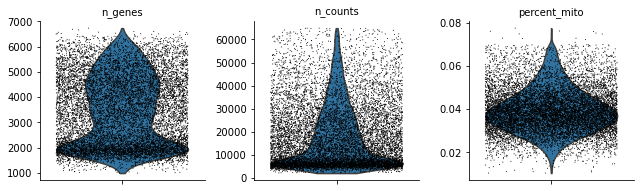

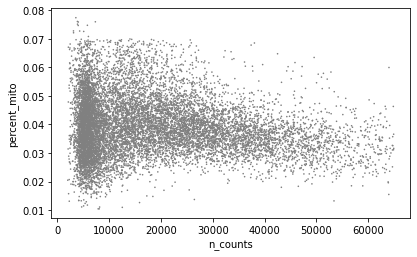

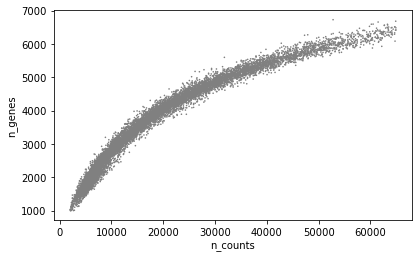

In [29]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4,multi_panel=True)
sc.pl.scatter(adata, x='n_counts',y='percent_mito')
sc.pl.scatter(adata,x='n_counts',y='n_genes')

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, sharey=False, figsize=(12,4), constrained_layout=True, dpi=160)
sns.violinplot(y=adata.obs['n_genes'],ax=axes[0,0])
sns.stripplot(y=adata.obs['n_genes'],color='black',s=2,ax=axes[0,0],alpha=0.2)

sns.violinplot(y=adata.obs['n_counts'], ax=axes[0,1])
sns.stripplot(y=adata.obs['n_counts'], color='black', s=2, ax=axes[0,1], alpha=0.2)

sns.violinplot(y=adata.obs['percent_mito'], ax=axes[0,2])
sns.stripplot(y=adata.obs['percent_mito'], color='black', s=2, ax=axes[0,2], alpha=0.2)

sns.scatterplot(x=adata.obs['n_counts'], y=adata.obs['percent_mito'], 
                ax=axes[1,0], color='black', s=2)
sns.scatterplot(x=adata.obs['n_counts'], y=adata.obs['n_genes'], 
                ax=axes[1,1], color='black', s=2)

axes[-1][-1].axis('off')

In [ ]:
adata

In [30]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [ ]:
adata

In [ ]:
adata.obs['n_counts'][0:3]

In [31]:
sc.pp.log1p(adata)

In [32]:
sc.pp.highly_variable_genes(adata,min_mean=0.002,max_mean=10,min_disp=0.1)

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
adata.var['means'][0:6]

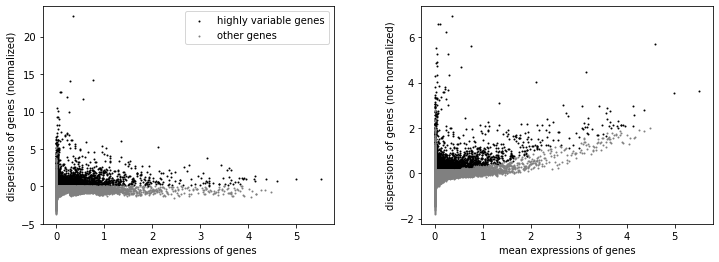

In [33]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata

In [34]:
adata.raw = adata


In [ ]:
adata

In [35]:
adata = adata[:,adata.var['highly_variable']]

In [33]:
adata

View of AnnData object with n_obs × n_vars = 11724 × 4645
    obs: 'cell_type', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [ ]:
adata.obs['n_counts'][0:8]

In [ ]:
adata.obs['cell_type'][0:8]

In [36]:
sc.pp.regress_out(adata,['n_counts'])

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:08:37)


In [37]:
sc.pp.scale(adata,max_value=10)

In [36]:
os.chdir('/mnt/d/Huitian_Practice/exp391/1_Scanpy_2')

In [37]:
code_dir = os.getcwd()
write_flag = True
write_dir = code_dir + '/counts_XL_folder'
Path(write_dir).mkdir(parents=True,exist_ok=True)
if write_flag:
    raw_array = adata.X
    pd_raw_df = pd.DataFrame(raw_array)
    pd_raw_df.columns = list(adata.var.index.values)
    col_names = list(pd_raw_df.columns.values)
    pd_raw_df.index = list(adata.obs.index.values)
    pd_raw_df.to_csv("%s/all_norm_counts_named_log_scaled.csv"%write_dir)

In [39]:
sc.tl.pca(adata,svd_solver='arpack')
sc.pp.neighbors(adata,n_neighbors=fa_n_denoise,n_pcs=fa_pc_denoise)
sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:30)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:05)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:08:28)


... storing 'y_pred' as categorical


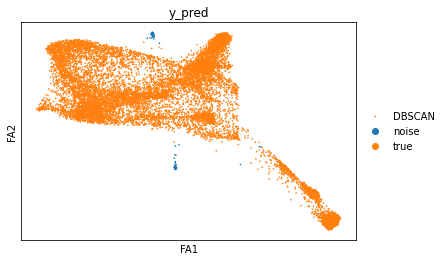

Counter({'true': 11622, 'noise': 102})


In [40]:
adata_fa = pd.DataFrame(adata.obsm["X_draw_graph_fa"])
clustering = DBSCAN(eps=12000,min_samples=100).fit(adata.obsm["X_draw_graph_fa"])
y_pred = ["noise" if x == -1 else "true" for x in list(clustering.labels_)]
Counter(y_pred)
adata.obs["y_pred"] =  y_pred
sc.pl.draw_graph(adata,color='y_pred',label="DBSCAN")

print(Counter(list(y_pred)))
adata = adata[adata.obs["y_pred"] == "true"]

In [ ]:
outname_base = "exp391"

In [41]:
del adata.obsm
del adata.uns
del adata.varm
del adata.obsp
adata.write("%s_outlier_removed.h5ad"%outname_base)

In [42]:
adata.obs.groupby("cell_type").count()

,n_genes,percent_mito,n_counts,y_pred
cell_type,,,,
A5P,2464,2464,2464,2464
A5T,2733,2733,2733,2733
A8P,1132,1132,1132,1132
A8T,1486,1486,1486,1486
C5P,2138,2138,2138,2138
C8P,761,761,761,761
NP14B,908,908,908,908


In [43]:
if True:
    cell_type_use = []
    cell_type_set = list(set(adata.obs['cell_type']))
    print(Counter(list(adata.obs['cell_type'])))
    cell_type_dict = {key:0 for key in cell_type_set}
    for i in list(adata.obs['cell_type']):
        cell_type_dict[i] += 1
        if cell_type_dict[i] <= max_n_per_cond:
            cell_type_use.append("Yes")
        else:
            cell_type_use.append("No")
            
    adata.obs['use'] = cell_type_use
    adata = adata[adata.obs['use'] == "Yes", :]
    print(Counter(list(adata.obs['cell_type'])))
    
adata.write("%s_resampled.h5ad"%outname_base)

Counter({'A5T': 2733, 'A5P': 2464, 'C5P': 2138, 'A8T': 1486, 'A8P': 1132, 'NP14B': 908, 'C8P': 761})


Trying to set attribute `.obs` of view, copying.


Counter({'C5P': 1250, 'A8T': 1250, 'A5P': 1250, 'A5T': 1250, 'A8P': 1132, 'NP14B': 908, 'C8P': 761})


... storing 'use' as categorical


In [44]:
adata = sc.read_h5ad("%s_resampled.h5ad"%outname_base)

In [45]:
adata

AnnData object with n_obs × n_vars = 7801 × 4645
    obs: 'cell_type', 'n_genes', 'percent_mito', 'n_counts', 'y_pred', 'use'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'

In [46]:
sc.tl.pca(adata,svd_solver='arpack')
sc.pp.neighbors(adata,n_neighbors=fa_n,n_pcs=fa_pc)
sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:15)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:05:28)


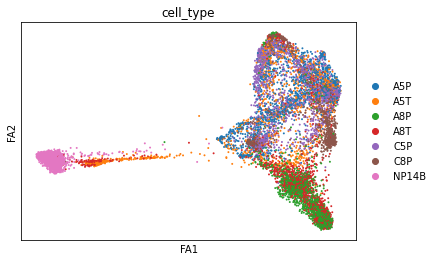

In [47]:
sc.pl.draw_graph(adata,color='cell_type')

In [48]:
adata.write("%s_resampled_nn.h5ad"%outname_base)

In [49]:
adata = sc.read_h5ad("%s_resampled_nn.h5ad"%outname_base)

In [50]:
sc.tl.louvain(adata,resolution=1.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:33)


----
Counter({'0': 1189, '1': 1027, '2': 953, '3': 922, '4': 900, '5': 739, '6': 593, '7': 472, '8': 419, '9': 330, '10': 257})
----
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:08)
--> added 'pos', the PAGA positions (adata.uns['paga'])


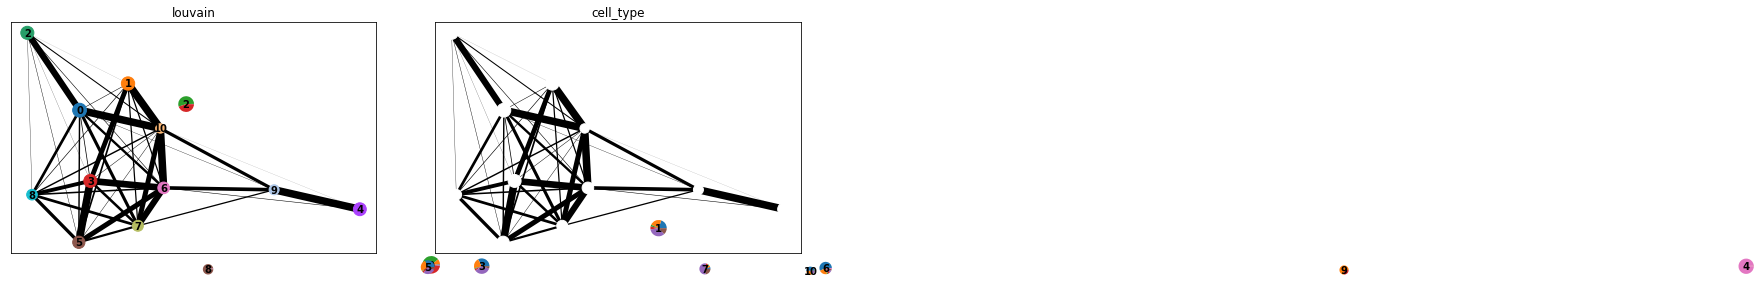

In [51]:
print("----")
print(Counter(list(adata.obs['louvain'])))
print("----")
sc.tl.paga(adata,groups='louvain')
sc.pl.paga(adata,color=['louvain','cell_type'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


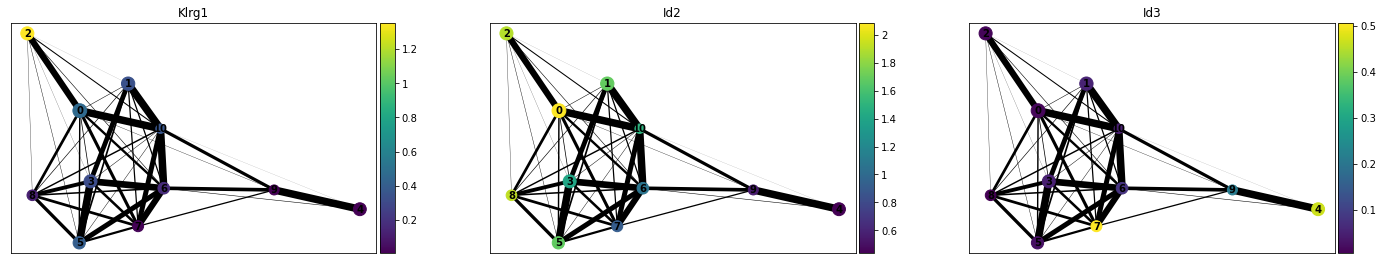

In [52]:
sc.pl.paga(adata,color=['Klrg1','Id2','Id3'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


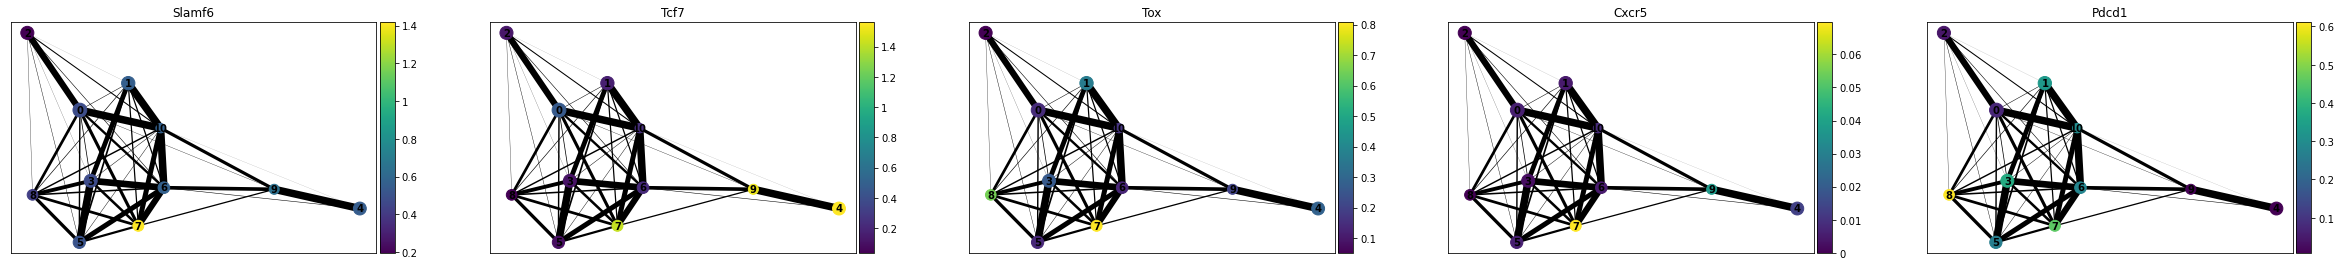

In [53]:
sc.pl.paga(adata,color=['Slamf6','Tcf7','Tox','Cxcr5','Pdcd1'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


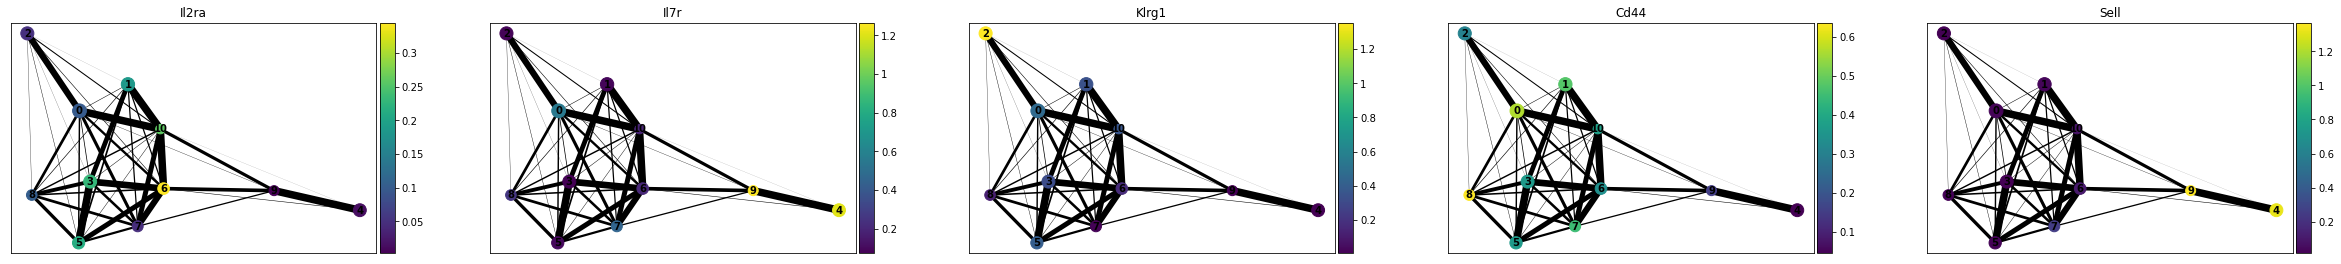

In [54]:
sc.pl.paga(adata,color=['Il2ra','Il7r','Klrg1','Cd44','Sell'])

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:05:13)


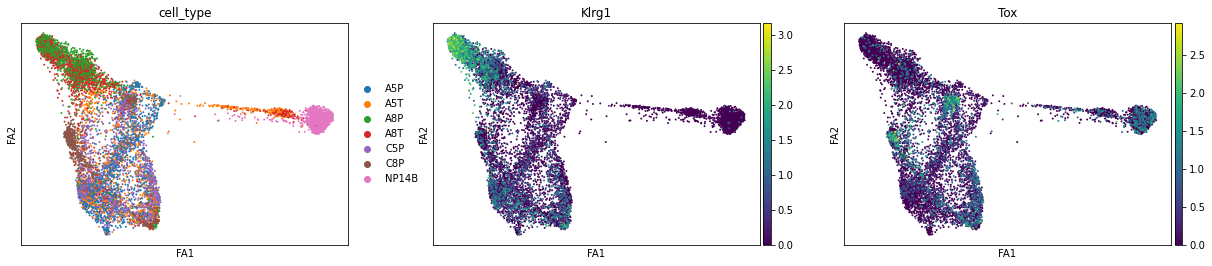

In [55]:
sc.tl.draw_graph(adata,init_pos='paga')
sc.pl.draw_graph(adata,color=['cell_type','Klrg1','Tox'])

In [56]:
adata.write("%s_paga_prePseudotime.h5ad"%outname_base)

In [ ]:
adata

In [57]:
adata = sc.read_h5ad("%s_paga_prePseudotime.h5ad"%outname_base)

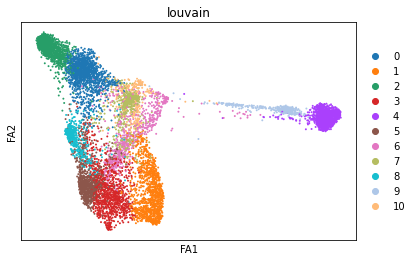

In [58]:
sc.pl.draw_graph(adata,color=['louvain'], save='louvain.png')

In [59]:
adata.obs['day'] = [x[1] for x in adata.obs['cell_type']]

In [60]:
adata.obs['day'] = [x.replace("P","0") for x in adata.obs['day']]

In [61]:
adata.obs['day'][0:4]

AAACCCAAGAGGCGTT-1    8
AAACCCACAATGACCT-1    5
AAACCCACACGACAAG-1    0
AAACCCACAGAGGTAC-1    8
Name: day, dtype: object

In [62]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_type'] == "NP14B")[0]

In [63]:
p14nav_array = np.flatnonzero(adata.obs['cell_type'] == 'NP14B')

In [ ]:
# based on plotting switching 3 for 4 in code below relative to huitian original
##louvain0_array = np.flatnonzero(adata.obs['louvain'] =='3')
##p14nav_louvain0_array = np.intersect1d(p14nav_array,louvain0_array)

In [64]:
louvain0_array = np.flatnonzero(adata.obs['louvain'] =='4')
p14nav_louvain0_array = np.intersect1d(p14nav_array,louvain0_array)

In [65]:
p14nav_louvain0_array

array([   2,   13,   59,   62,   95,  106,  149,  160,  164,  184,  189,
        200,  206,  228,  246,  251,  275,  280,  281,  285,  296,  311,
        325,  332,  333,  336,  340,  342,  369,  389,  390,  392,  413,
        467,  484,  493,  494,  506,  525,  548,  567,  574,  592,  597,
        604,  612,  617,  635,  643,  664,  670,  673,  674,  681,  689,
        697,  699,  706,  731,  737,  775,  807,  840,  850,  854,  858,
        869,  873,  893,  894,  897,  898,  935,  941,  945,  957,  965,
        970,  986,  994, 1019, 1023, 1031, 1047, 1083, 1149, 1175, 1204,
       1226, 1235, 1275, 1354, 1369, 1370, 1378, 1388, 1408, 1415, 1429,
       1446, 1463, 1469, 1472, 1483, 1519, 1523, 1551, 1577, 1579, 1582,
       1606, 1629, 1676, 1682, 1685, 1713, 1724, 1734, 1773, 1774, 1783,
       1801, 1807, 1808, 1818, 1824, 1826, 1829, 1831, 1893, 1911, 1913,
       1917, 1928, 1929, 1943, 1960, 1968, 1969, 1971, 1975, 1977, 1990,
       1996, 2006, 2017, 2024, 2035, 2039, 2077, 20

In [66]:
adata.uns['iroot'] = p14nav_louvain0_array[0]

In [67]:
adata.uns['iroot']

2

In [68]:
sc.tl.dpt(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9920506  0.9693392  0.9435042  0.931836   0.92374456
     0.91924196 0.9088024  0.89428616 0.87701976 0.865984   0.8559085
     0.84938216 0.84460646 0.8397016 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:08)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


... storing 'day' as categorical


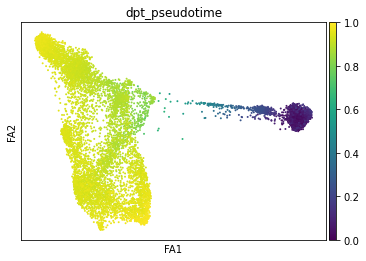

In [69]:
sc.pl.draw_graph(adata,color=['dpt_pseudotime'])

In [70]:
adata.write_csvs("%s_paga"%outname_base)

writing .csv files to exp391_paga


In [71]:
adata.write("%s_paga.h5ad"%outname_base)

In [72]:
paga_connect = pd.DataFrame(adata.uns['paga']['connectivities'].A)
paga_connect_tree = pd.DataFrame(adata.uns['paga']['connectivities_tree'].A)
paga_pos = pd.DataFrame(adata.uns['paga']['pos'])

paga_connect.to_csv("%s_paga/paga_connect.csv"%outname_base, sep=',')
paga_connect_tree.to_csv("%s_paga/paga_connect_tree.csv"%outname_base,sep=',')
paga_pos.to_csv("%s_paga/paga_pos.csv"%outname_base, sep=',')

In [73]:
adata = sc.read_h5ad("%s_paga.h5ad"%outname_base)

In [ ]:
os.getcwd()

In [ ]:
code_dir

In [74]:
sum_dir = code_dir + "/0_sum"
Path(sum_dir).mkdir(parents=True,exist_ok = True)
os.chdir(sum_dir)

In [75]:
cell_type_uniq = list(set(list(adata.obs['cell_type'])))
louvain_uniq = list(set(list(adata.obs['louvain'])))
louvain_uniq_use = list(set(range(0,max([int(i) for i in louvain_uniq])+1 )))


In [76]:
louvain_uniq_use

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [77]:
louvain_uniq

['5', '8', '10', '2', '1', '7', '3', '9', '4', '6', '0']

In [78]:
louvain_type_count_tb = pd.DataFrame(data= {'louvain':louvain_uniq_use})
louvain_type_pctg_tb = pd.DataFrame(data = {'louvain':louvain_uniq_use})

In [79]:
louvain_type_count_tb

,louvain
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [80]:
for type_i in cell_type_uniq:
    number_i = []
    pctg_i = []
    typ_i_louvain = list(adata.obs[adata.obs['cell_type'] == type_i]["louvain"])
    for i in louvain_uniq_use:
        louvain_i_number = typ_i_louvain.count(str(i))
        louvain_i_pctg = float(louvain_i_number)*100/len(typ_i_louvain)
        number_i.append(louvain_i_number)
        pctg_i.append(louvain_i_pctg)
    louvain_type_count_tb[type_i] = number_i
    louvain_type_pctg_tb[type_i] = pctg_i
louvain_type_pctg_tb.to_csv("%s_Louvain--CellType_pctg.csv"%outname_base, index=False)
louvain_type_count_tb.to_csv("%s_Louvain--CellType_count.csv"%outname_base, index=False)

In [81]:
louvain_type_count_tb

,louvain,NP14B,C5P,C8P,A8P,A5T,A5P,A8T
0,0,1,14,4,503,116,14,537
1,1,0,357,131,36,242,201,60
2,2,1,1,0,522,3,1,425
3,3,0,324,46,16,201,302,33
4,4,887,0,1,1,2,0,9
5,5,0,213,43,11,210,231,31
6,6,18,37,22,17,127,339,33
7,7,0,264,107,20,28,27,26
8,8,0,7,403,1,0,1,7
9,9,1,0,0,0,247,1,81


In [82]:
paga_connect = pd.DataFrame(adata.uns['paga']['connectivities'].A)
paga_connect_tree = pd.DataFrame(adata.uns['paga']['connectivities_tree'].A)
paga_pos = pd.DataFrame(adata.uns['paga']['pos'])

paga_connect.to_csv("%s_paga_connect.csv"%outname_base,sep=',')
paga_connect_tree.to_csv("%s_paga_connect_tree.csv"%outname_base,sep=",")
paga_pos.to_csv("%s_paga_pos.csv"%outname_base, sep=",")

In [83]:
adata.obs['counts_per_gene'] = adata.obs['n_counts']/adata.obs['n_genes']
adata_obs_mean = adata.obs.groupby(['louvain']).mean()
adata_obs_mean = adata_obs_mean.sort_values(by='dpt_pseudotime')
adata_obs_mean.to_csv("%s_obs_louvainAvg.csv"%outname_base)
adata_obs_mean

,n_genes,percent_mito,n_counts,dpt_pseudotime,counts_per_gene
louvain,,,,,
4,1848.371111,0.047450,5690.302246,0.050918,3.061188
9,2004.751515,0.035731,7175.582031,0.264919,3.470098
6,5023.785835,0.035346,37826.035156,0.843688,7.075989
10,5638.108949,0.036450,46278.937500,0.874894,7.953770
7,3444.461864,0.048028,15991.741211,0.882806,4.408364
0,2367.350715,0.038217,7830.234863,0.915631,3.160205
5,3742.370771,0.038570,18402.150391,0.935071,4.696663
3,3906.114967,0.042657,20071.634766,0.936789,4.903573
8,2792.715990,0.035416,10161.834961,0.938191,3.459408


In [84]:
adata_obs_mean = adata.obs.groupby(['cell_type']).mean()
adata_obs_mean = adata_obs_mean.sort_values(by='dpt_pseudotime')
adata_obs_mean.to_csv("%s_obs_ctAvg.csv"%outname_base)

In [85]:
adata_obs_mean

,n_genes,percent_mito,n_counts,dpt_pseudotime,counts_per_gene
cell_type,,,,,
NP14B,1850.168502,0.047442,5674.370117,0.059630,3.054580
A5T,3706.848000,0.036752,20816.617188,0.790988,5.059081
A8T,2202.864000,0.038889,7046.847168,0.875965,3.075019
A5P,4795.260000,0.038573,32174.609375,0.906216,6.395952
C5P,4051.462400,0.043488,21671.189453,0.923125,5.080670
A8P,2180.500883,0.035328,6696.652832,0.933408,2.948668
C8P,3124.399474,0.037650,12844.114258,0.934945,3.818309


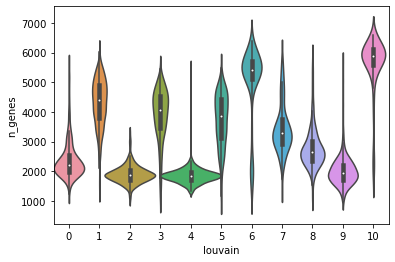

In [86]:
sns.violinplot(x='louvain',y='n_genes',data=adata.obs,width=2)

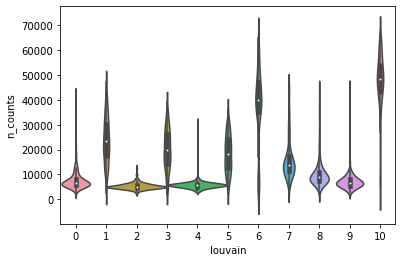

In [87]:
sns.violinplot(x='louvain',y="n_counts",data=adata.obs,width=2)

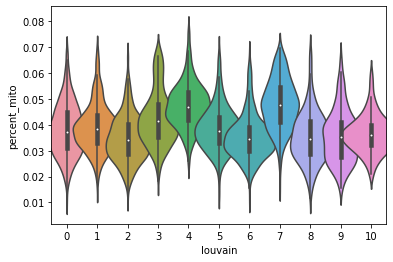

In [88]:
sns.violinplot(x="louvain",y='percent_mito',data=adata.obs,width=2)

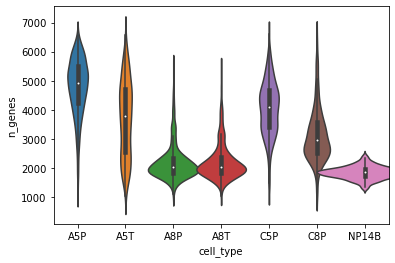

In [89]:
sns.violinplot(x='cell_type',y='n_genes',data=adata.obs,width=2)

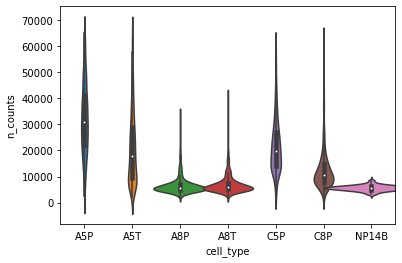

In [90]:
sns.violinplot(x='cell_type',y='n_counts',data=adata.obs,width=2)

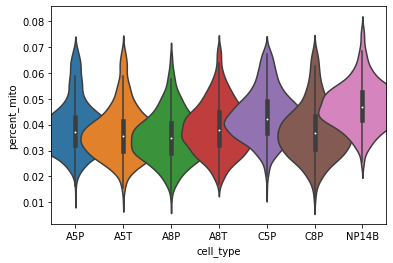

In [91]:
sns.violinplot(x='cell_type',y='percent_mito',data=adata.obs,width=2)

In [92]:
sum_dir = code_dir + "/1_avg_expr"
Path(sum_dir).mkdir(parents=True,exist_ok=True)
os.chdir(sum_dir)

In [93]:
adata.obs['louvain_celltype'] = ["%s_%s"%(str(y),str(x)) for index, (x,y) in enumerate(zip(adata.obs['cell_type'].values, adata.obs['louvain'].values))]
adata.obs['louvain_celltype_general'] = ["%s_%s"%(str(y), str(x)[0]) for index, (x,y) in enumerate(zip(adata.obs['cell_type'].values, adata.obs['louvain'].values))]
adata.obs['cell_type_simp'] = [x[:-1] for x in adata.obs['cell_type']]
adata.obs['cell_type_simp'] = ["NAV" if x == 'NP14' else x for x in adata.obs['cell_type_simp']]

In [95]:
adata.obs['cell_type_simp'][0:4]

AAACCCAAGAGGCGTT-1     C8
AAACCCACAATGACCT-1     C5
AAACCCACACGACAAG-1    NAV
AAACCCACAGAGGTAC-1     A8
Name: cell_type_simp, dtype: object

In [96]:
use_cols = ['cell_type_simp']
expr_df = pd.DataFrame(adata.X)
expr_df.index = adata.obs.index
expr_df.columns = adata.var.index
expr_df.columns.name = ''

for use_key in use_cols:
    use_key_type = np.unique(adata.obs[use_key])
    use_key_df = expr_df.join(adata.obs[[use_key]])
    use_key_mean_df = use_key_df.groupby(use_key).mean().T
    use_key_mean_df.columns.name = ""
    use_key_mean_df.index.name = 'gene_name'
    use_key_mean_df.to_csv("%s_mean_scaled_expr.csv"%use_key)
    use_key_z_df = use_key_mean_df.apply(lambda x: stats.zscore(x),axis=0)
    use_key_z_df.to_csv("%s_mean_scaled_expr_z.csv"%use_key)

In [97]:
adata.obs['louvain_celltype_general_A'] = [x.replace("N","A") for x in adata.obs['louvain_celltype_general']]
adata.obs['louvain_celltype_general_A'] = ["other" if "A" not in x else x for x in adata.obs['louvain_celltype_general_A']]

use_cols = ['louvain_celltype_general_A']

expr_df = pd.DataFrame(adata.X)
expr_df.index = adata.obs.index
expr_df.columns = adata.var.index
expr_df.columns.name = ''

for use_key in use_cols:
    use_key_types = np.unique(adata.obs[use_key])
    use_key_df = expr_df.join(adata.obs[[use_key]])
    use_key_mean_df = use_key_df.groupby(use_key).mean().T
    use_key_mean_df.columns.name = ""
    use_key_mean_df.index.name = "gene_name"
    use_key_z_df = use_key_mean_df.apply(lambda x: stats.zscore(x),axis=0)
    del use_key_z_df['other']
    del use_key_mean_df['other']
use_key_mean_df_all = use_key_mean_df
use_key_z_df_all = use_key_z_df

adata.obs['louvain_celltype_general_C'] = [x.replace("N","C") for x in adata.obs['louvain_celltype_general']]
adata.obs['louvain_celltype_general_C'] = ["other" if "C" not in x else x for x in adata.obs['louvain_celltype_general_C']]

use_cols = ['louvain_celltype_general_C']

expr_df = pd.DataFrame(adata.X)
expr_df.index = adata.obs.index
expr_df.columns = adata.var.index
expr_df.columns.name = ''

for use_key in use_cols:
    use_key_type = np.unique(adata.obs[use_key])
    use_key_df = expr_df.join(adata.obs[[use_key]])
    use_key_mean_df = use_key_df.groupby(use_key).mean().T
    use_key_mean_df.columns.name = ""
    use_key_mean_df.index.name = "gene_name"
    use_key_z_df = use_key_mean_df.apply(lambda x: stats.zscore(x),axis=0)
    del use_key_z_df['other']
    del use_key_mean_df['other']
use_key_mean_df_all = use_key_mean_df_all.join(use_key_mean_df)
use_key_z_df_all = use_key_z_df_all.join(use_key_z_df)

use_key_mean_df_all.to_csv('louvain_celltype_general_withNAV_mean_scaled_expr.csv')
use_key_z_df_all.to_csv("louvain_celltype_general_withNAV_mean_scaled_expr_z.csv")